🍷 Wine Quality Prediction System
Setting up environment for Mr. Sanborn's Quality Assurance Team
✅ Successfully loaded dataset: winequality-red-selected-missing.csv

📊 Dataset Overview:
Shape: (1599, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1388 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density         

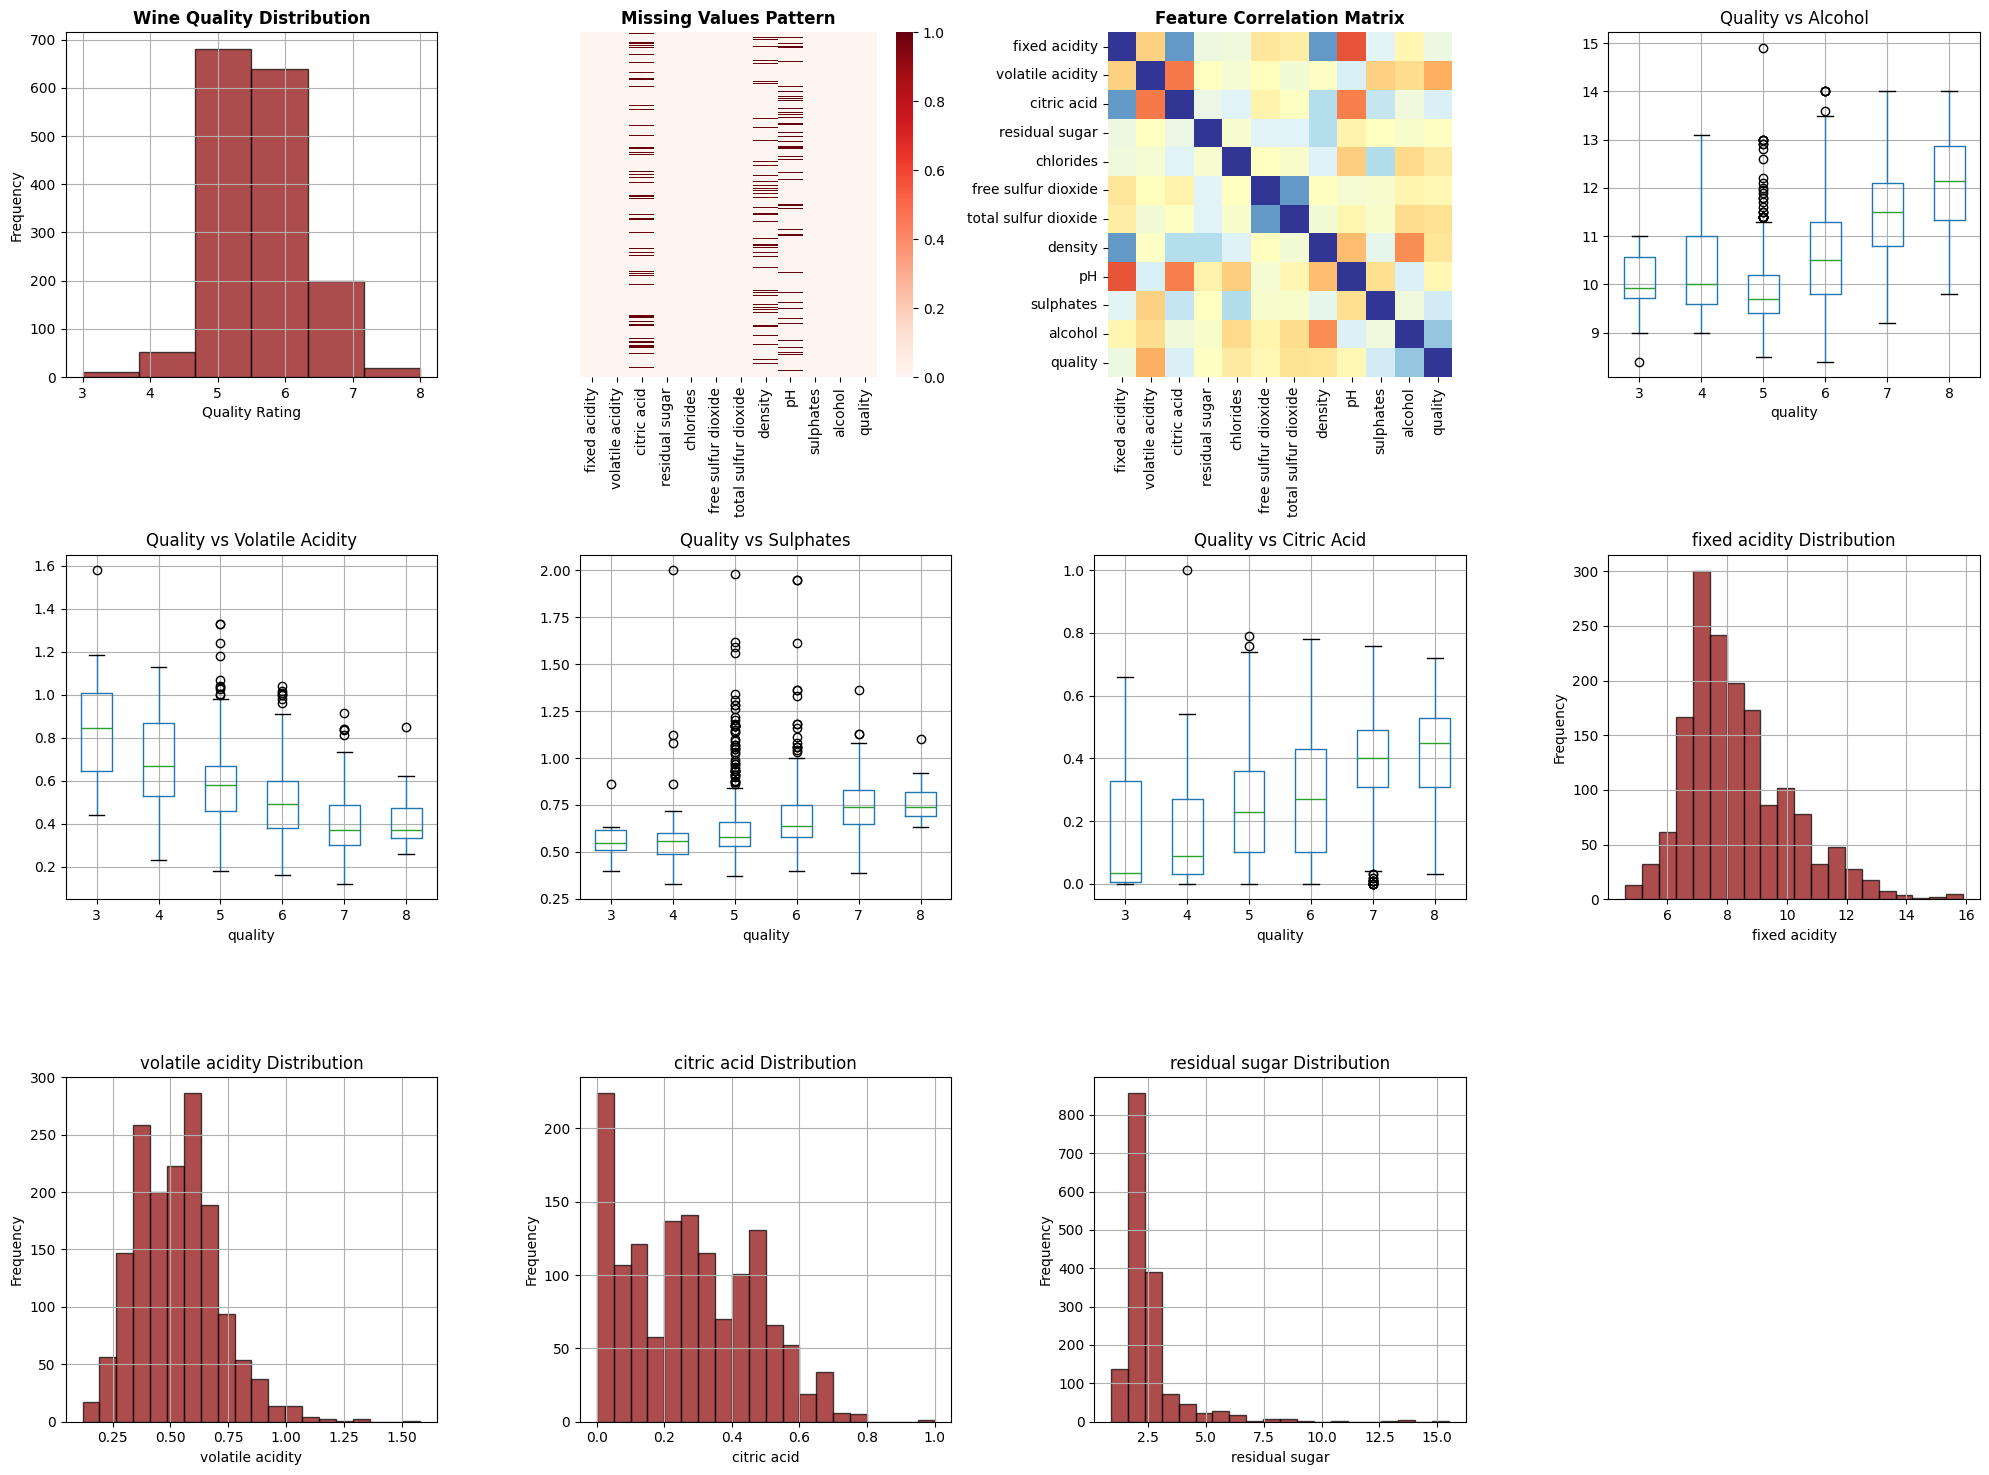

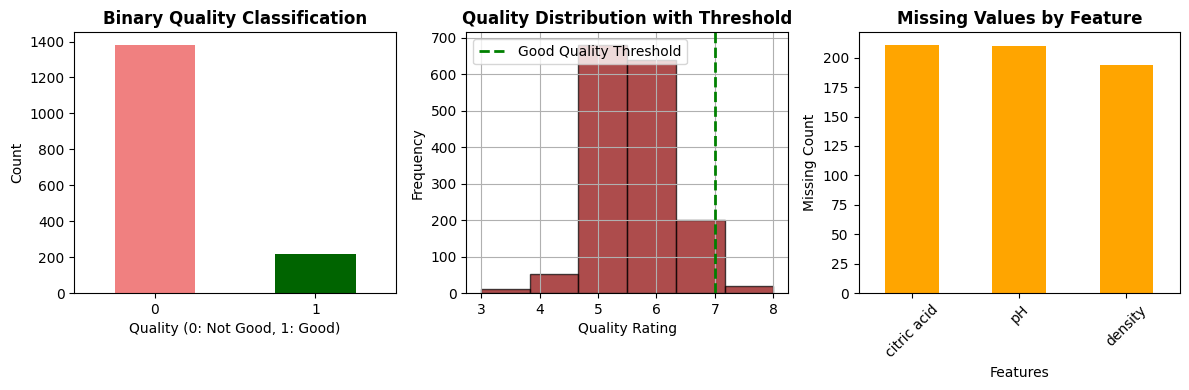


🤖 Training Machine Learning Models...

📈 Training Logistic Regression...
✅ Logistic Regression Results:
   Test Accuracy: 0.8938
   ROC AUC: 0.8744
   CV Accuracy: 0.8733 (+/- 0.0268)

📈 Training Random Forest...
✅ Random Forest Results:
   Test Accuracy: 0.9375
   ROC AUC: 0.9492
   CV Accuracy: 0.8890 (+/- 0.0317)

🏆 Best Model: Random Forest
ROC AUC Score: 0.9492

📊 Creating Model Evaluation Visualizations...


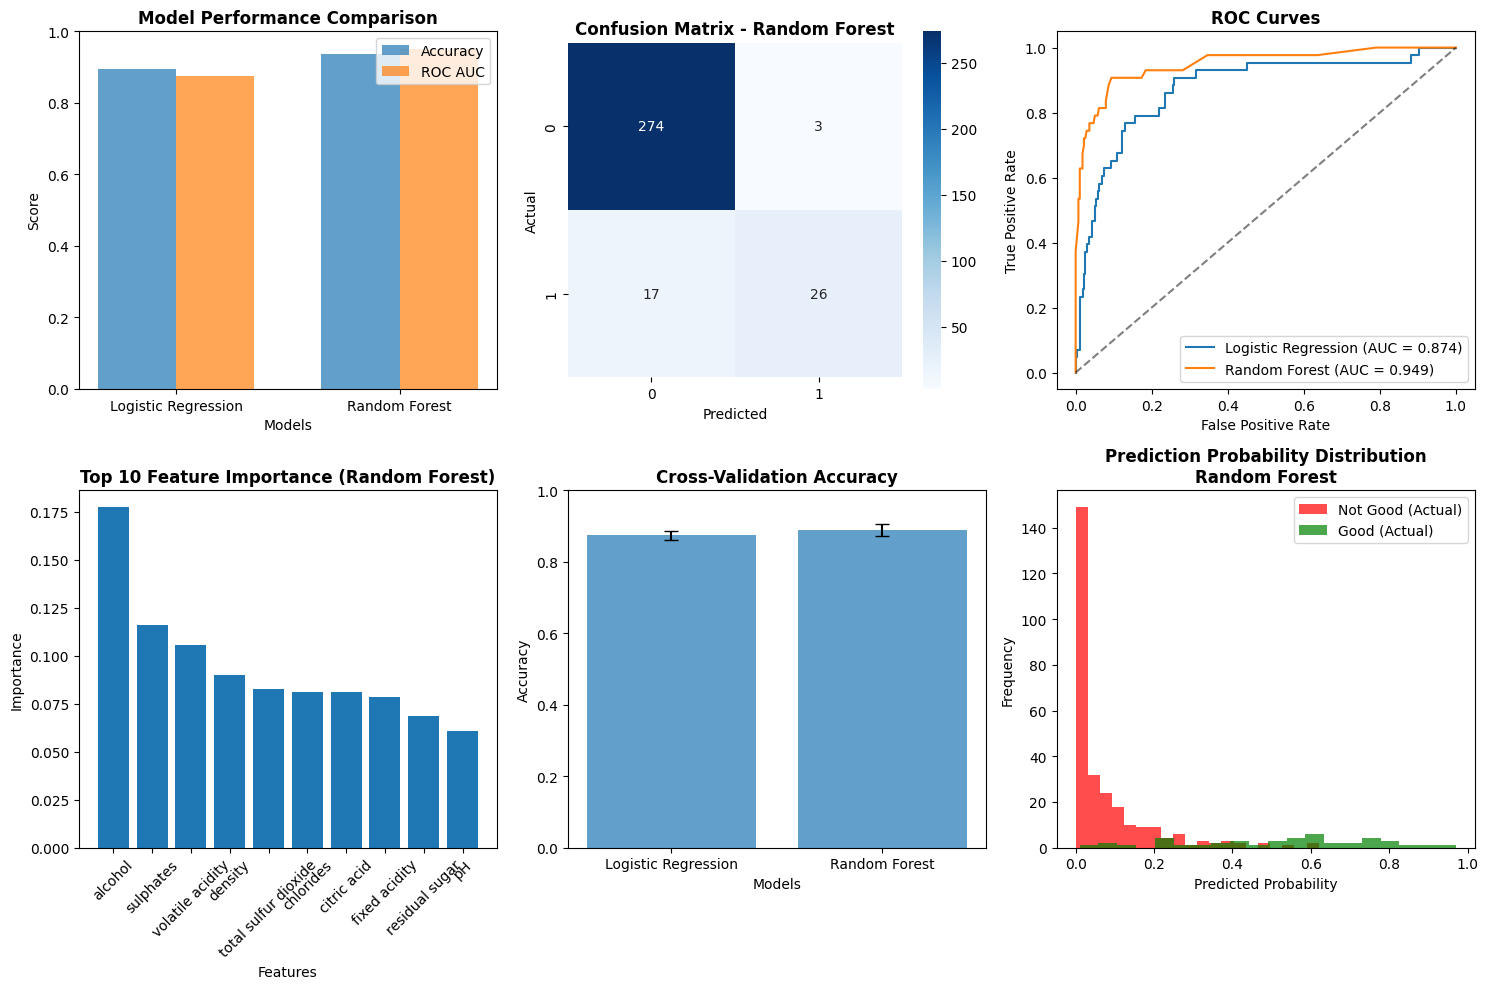


📋 Detailed Classification Report - Random Forest:
                  precision    recall  f1-score   support

Not Good Quality       0.94      0.99      0.96       277
    Good Quality       0.90      0.60      0.72        43

        accuracy                           0.94       320
       macro avg       0.92      0.80      0.84       320
    weighted avg       0.94      0.94      0.93       320


💾 Saving Model Components...
✅ Model saved as 'wine_quality_model.pkl'

🌐 Creating Web Application...
✅ Web application created successfully!
🚀 Launching application...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0359e814d09b054f81.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Wine Quality Prediction System for Boutique Winery
# Google Colab Implementation for Mr. Sanborn's Quality Assurance Team

# ===================================================================
# SECTION 1: SETUP AND DATA LOADING
# ===================================================================

# Install required packages
!pip install gradio scikit-learn pandas numpy matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import gradio as gr
import pickle
import warnings
warnings.filterwarnings('ignore')

print("🍷 Wine Quality Prediction System")
print("=" * 50)
print("Setting up environment for Mr. Sanborn's Quality Assurance Team")

# ===================================================================
# SECTION 2: DATA LOADING AND EXPLORATION
# ===================================================================

def load_and_explore_data():
    """Load the wine dataset and perform initial exploration"""

    # Load the dataset
    # Note: Make sure to upload 'winequality-red-selected-missing' to your Colab environment
    try:
        # Try different file extensions
        for ext in ['.csv', '.txt', '.data']:
            try:
                if ext == '.csv':
                    df = pd.read_csv(f'winequality-red-selected-missing{ext}')
                else:
                    df = pd.read_csv(f'winequality-red-selected-missing{ext}', sep=';' if ext == '.txt' else None)
                print(f"✅ Successfully loaded dataset: winequality-red-selected-missing{ext}")
                break
            except:
                continue
    except:
        print("❌ Dataset not found. Please upload 'winequality-red-selected-missing' file to Colab.")
        print("💡 You can upload files using the Files panel on the left sidebar.")
        return None

    print(f"\n📊 Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Display basic info
    print(f"\n📈 Dataset Info:")
    print(df.info())

    # Display first few rows
    print(f"\n🔍 First 5 rows:")
    print(df.head())

    # Check for missing values
    print(f"\n❓ Missing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent.round(2)
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    print(missing_df)

    # Quality distribution
    print(f"\n🎯 Quality Distribution:")
    quality_dist = df['quality'].value_counts().sort_index()
    print(quality_dist)

    return df

# Load and explore the data
df = load_and_explore_data()

# ===================================================================
# SECTION 3: DATA PREPROCESSING AND FEATURE ENGINEERING
# ===================================================================

def preprocess_wine_data(df):
    """Comprehensive data preprocessing for wine quality prediction"""

    if df is None:
        return None, None, None, None, None, None

    print("\n🔧 Starting Data Preprocessing...")

    # Create a copy for processing
    data = df.copy()

    # Create binary target variable (Good = 7+, Not Good = <7)
    data['is_good_quality'] = (data['quality'] >= 7).astype(int)

    print(f"Quality Distribution:")
    print(f"Good Quality (≥7): {data['is_good_quality'].sum()} samples ({data['is_good_quality'].mean()*100:.1f}%)")
    print(f"Not Good Quality (<7): {(1-data['is_good_quality']).sum()} samples ({(1-data['is_good_quality'].mean())*100:.1f}%)")

    # Separate features and target
    feature_columns = [col for col in data.columns if col not in ['quality', 'is_good_quality']]
    X = data[feature_columns]
    y = data['is_good_quality']

    # Handle missing values using multiple strategies
    print(f"\n🔄 Handling Missing Values...")

    # Strategy 1: Mean imputation for numerical features
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    print("✅ Missing values handled using mean imputation")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"✅ Data split into training ({len(X_train)}) and testing ({len(X_test)}) sets")
    print("✅ Features scaled using StandardScaler")

    return X_train_scaled, X_test_scaled, y_train, y_test, imputer, scaler

# Preprocess the data
X_train, X_test, y_train, y_test, imputer, scaler = preprocess_wine_data(df)

# ===================================================================
# SECTION 4: DATA VISUALIZATION
# ===================================================================

def create_visualizations(df):
    """Create comprehensive visualizations for wine quality analysis"""

    if df is None:
        return

    print("\n📊 Creating Data Visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))

    # 1. Quality distribution
    plt.subplot(3, 4, 1)
    df['quality'].hist(bins=6, alpha=0.7, color='darkred', edgecolor='black')
    plt.title('Wine Quality Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Quality Rating')
    plt.ylabel('Frequency')

    # 2. Missing values heatmap
    plt.subplot(3, 4, 2)
    sns.heatmap(df.isnull(), cbar=True, cmap='Reds', yticklabels=False)
    plt.title('Missing Values Pattern', fontsize=12, fontweight='bold')

    # 3. Correlation matrix
    plt.subplot(3, 4, 3)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=False, cmap='RdYlBu', center=0, square=True, cbar=False)
    plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

    # 4. Quality vs key features
    feature_plots = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']

    for i, feature in enumerate(feature_plots[:4], 4):
        plt.subplot(3, 4, i)
        if feature in df.columns:
            df.boxplot(column=feature, by='quality', ax=plt.gca())
            plt.title(f'Quality vs {feature.title()}')
            plt.suptitle('')  # Remove automatic title
        else:
            # Find similar column name
            similar_cols = [col for col in df.columns if feature.replace(' ', '_') in col or feature.replace(' ', '.') in col]
            if similar_cols:
                df.boxplot(column=similar_cols[0], by='quality', ax=plt.gca())
                plt.title(f'Quality vs {similar_cols[0]}')
                plt.suptitle('')

    # 5-8. Distribution plots for key features
    key_features = df.select_dtypes(include=[np.number]).columns[:4]
    for i, feature in enumerate(key_features, 8):
        if i > 11:
            break
        plt.subplot(3, 4, i)
        df[feature].hist(bins=20, alpha=0.7, color='darkred', edgecolor='black')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Create a separate plot for binary classification
    plt.figure(figsize=(12, 4))

    # Binary quality distribution
    plt.subplot(1, 3, 1)
    binary_quality = (df['quality'] >= 7).astype(int)
    binary_quality.value_counts().plot(kind='bar', color=['lightcoral', 'darkgreen'])
    plt.title('Binary Quality Classification', fontweight='bold')
    plt.xlabel('Quality (0: Not Good, 1: Good)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # Quality rating distribution with threshold line
    plt.subplot(1, 3, 2)
    df['quality'].hist(bins=6, alpha=0.7, color='darkred', edgecolor='black')
    plt.axvline(x=7, color='green', linestyle='--', linewidth=2, label='Good Quality Threshold')
    plt.title('Quality Distribution with Threshold', fontweight='bold')
    plt.xlabel('Quality Rating')
    plt.ylabel('Frequency')
    plt.legend()

    # Missing values by feature
    plt.subplot(1, 3, 3)
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    if len(missing_data) > 0:
        missing_data.plot(kind='bar', color='orange')
        plt.title('Missing Values by Feature', fontweight='bold')
        plt.xlabel('Features')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center', fontsize=14)
        plt.title('Missing Values by Feature', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create visualizations
create_visualizations(df)

# ===================================================================
# SECTION 5: MODEL TRAINING AND EVALUATION
# ===================================================================

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train multiple models and compare their performance"""

    print("\n🤖 Training Machine Learning Models...")

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    results = {}

    for name, model in models.items():
        print(f"\n📈 Training {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_prob
        }

        print(f"✅ {name} Results:")
        print(f"   Test Accuracy: {accuracy:.4f}")
        print(f"   ROC AUC: {roc_auc:.4f}")
        print(f"   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return results

# Train models
if X_train is not None:
    model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Select the best model
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['roc_auc'])
    best_model = model_results[best_model_name]['model']

    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"ROC AUC Score: {model_results[best_model_name]['roc_auc']:.4f}")

# ===================================================================
# SECTION 6: MODEL EVALUATION AND VISUALIZATION
# ===================================================================

def evaluate_model_performance(model_results, y_test):
    """Create comprehensive model evaluation visualizations"""

    print("\n📊 Creating Model Evaluation Visualizations...")

    fig = plt.figure(figsize=(15, 10))

    # 1. Model comparison
    plt.subplot(2, 3, 1)
    model_names = list(model_results.keys())
    accuracies = [model_results[name]['accuracy'] for name in model_names]
    roc_aucs = [model_results[name]['roc_auc'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.7)
    plt.bar(x + width/2, roc_aucs, width, label='ROC AUC', alpha=0.7)

    plt.title('Model Performance Comparison', fontweight='bold')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.xticks(x, model_names)
    plt.legend()
    plt.ylim(0, 1)

    # 2. Confusion matrix for best model
    plt.subplot(2, 3, 2)
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['roc_auc'])
    y_pred = model_results[best_model_name]['predictions']

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
    plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 3. ROC Curve
    plt.subplot(2, 3, 3)
    for name in model_results.keys():
        y_prob = model_results[name]['probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = model_results[name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('ROC Curves', fontweight='bold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # 4. Feature importance (for Random Forest)
    plt.subplot(2, 3, 4)
    if 'Random Forest' in model_results:
        rf_model = model_results['Random Forest']['model']
        feature_importance = rf_model.feature_importances_

        # Get feature names
        if df is not None:
            feature_names = [col for col in df.columns if col not in ['quality', 'is_good_quality']][:len(feature_importance)]
        else:
            feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

        indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

        plt.bar(range(len(indices)), feature_importance[indices])
        plt.title('Top 10 Feature Importance (Random Forest)', fontweight='bold')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)

    # 5. Cross-validation scores
    plt.subplot(2, 3, 5)
    cv_means = [model_results[name]['cv_mean'] for name in model_names]
    cv_stds = [model_results[name]['cv_std'] for name in model_names]

    plt.bar(model_names, cv_means, yerr=cv_stds, alpha=0.7, capsize=5)
    plt.title('Cross-Validation Accuracy', fontweight='bold')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # 6. Prediction distribution
    plt.subplot(2, 3, 6)
    y_prob = model_results[best_model_name]['probabilities']

    # Separate probabilities by actual class
    prob_good = y_prob[y_test == 1]
    prob_not_good = y_prob[y_test == 0]

    plt.hist(prob_not_good, bins=20, alpha=0.7, label='Not Good (Actual)', color='red')
    plt.hist(prob_good, bins=20, alpha=0.7, label='Good (Actual)', color='green')
    plt.title(f'Prediction Probability Distribution\n{best_model_name}', fontweight='bold')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print(f"\n📋 Detailed Classification Report - {best_model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Not Good Quality', 'Good Quality']))

# Evaluate model performance
if X_train is not None:
    evaluate_model_performance(model_results, y_test)

# ===================================================================
# SECTION 7: SAVE MODEL AND PREPROCESSING COMPONENTS
# ===================================================================

def save_model_components(best_model, imputer, scaler, feature_names):
    """Save the trained model and preprocessing components"""

    print("\n💾 Saving Model Components...")

    # Create a model package
    model_package = {
        'model': best_model,
        'imputer': imputer,
        'scaler': scaler,
        'feature_names': feature_names
    }

    # Save to pickle file
    with open('wine_quality_model.pkl', 'wb') as f:
        pickle.dump(model_package, f)

    print("✅ Model saved as 'wine_quality_model.pkl'")

    return model_package

# Save model components
if X_train is not None:
    feature_names = [col for col in df.columns if col not in ['quality', 'is_good_quality']]
    model_package = save_model_components(best_model, imputer, scaler, feature_names)

# ===================================================================
# SECTION 8: GRADIO WEB APPLICATION
# ===================================================================

def create_wine_quality_app():
    """Create a Gradio web application for wine quality prediction"""

    def predict_wine_quality(*inputs):
        """Make wine quality prediction"""

        try:
            # Load model if not already loaded
            if 'model_package' not in globals():
                print("Loading saved model...")
                with open('wine_quality_model.pkl', 'rb') as f:
                    model_package = pickle.load(f)

            # Get feature names
            feature_names = model_package['feature_names']

            # Create input array
            input_data = np.array(inputs).reshape(1, -1)
            input_df = pd.DataFrame(input_data, columns=feature_names)

            # Handle missing values (NaN inputs)
            input_imputed = model_package['imputer'].transform(input_df)

            # Scale features
            input_scaled = model_package['scaler'].transform(input_imputed)

            # Make prediction
            prediction = model_package['model'].predict(input_scaled)[0]
            probability = model_package['model'].predict_proba(input_scaled)[0]

            # Format results
            quality_label = "Good Quality Wine (≥7)" if prediction == 1 else "Not Good Quality Wine (<7)"
            confidence = max(probability) * 100

            # Create detailed response
            result = f"""
            🍷 **Wine Quality Prediction Results**

            **Quality Classification:** {quality_label}

            **Confidence Score:** {confidence:.1f}%

            **Probability Breakdown:**
            - Not Good Quality: {probability[0]:.3f} ({probability[0]*100:.1f}%)
            - Good Quality: {probability[1]:.3f} ({probability[1]*100:.1f}%)

            **Interpretation:**
            {interpret_confidence(confidence, prediction)}

            **Recommendation for Mr. Sanborn's Team:**
            {get_recommendation(confidence, prediction)}
            """

            return result

        except Exception as e:
            return f"Error making prediction: {str(e)}"

    def interpret_confidence(confidence, prediction):
        """Interpret the confidence score"""
        quality = "good" if prediction == 1 else "not good"

        if confidence >= 90:
            return f"Very high confidence that this wine is {quality} quality. The model is very certain about this prediction."
        elif confidence >= 80:
            return f"High confidence that this wine is {quality} quality. The model is quite certain about this prediction."
        elif confidence >= 70:
            return f"Moderate confidence that this wine is {quality} quality. Consider additional testing for verification."
        elif confidence >= 60:
            return f"Low-moderate confidence that this wine is {quality} quality. Recommend expert evaluation."
        else:
            return f"Low confidence in the prediction. Strong recommendation for expert evaluation and additional testing."

    def get_recommendation(confidence, prediction):
        """Get business recommendation"""
        if prediction == 1:  # Good quality
            if confidence >= 80:
                return "✅ Approve for premium wine selection. High confidence in quality."
            elif confidence >= 70:
                return "⚠️ Likely suitable for premium selection, but consider sensory evaluation."
            else:
                return "🔍 Requires expert tasting and additional quality assessment before approval."
        else:  # Not good quality
            if confidence >= 80:
                return "❌ Not suitable for premium wine selection. High confidence in classification."
            elif confidence >= 70:
                return "⚠️ Likely not suitable for premium selection, but consider expert review."
            else:
                return "🔍 Uncertain classification. Recommend expert evaluation to determine quality level."

    # Create Gradio interface
    if df is not None:
        feature_names = [col for col in df.columns if col not in ['quality', 'is_good_quality']]

        # Create input components
        inputs = []
        for feature in feature_names:
            # Get reasonable default values based on data
            if feature in df.columns:
                default_val = df[feature].mean()
                min_val = df[feature].min()
                max_val = df[feature].max()
            else:
                default_val, min_val, max_val = 0.5, 0.0, 1.0

            inputs.append(
                gr.Number(
                    value=default_val,
                    minimum=min_val,
                    maximum=max_val,
                    label=feature.replace('_', ' ').title(),
                    info=f"Range: {min_val:.2f} - {max_val:.2f}"
                )
            )

        # Create the interface
        interface = gr.Interface(
            fn=predict_wine_quality,
            inputs=inputs,
            outputs=gr.Markdown(label="Prediction Results"),
            title="🍷 Wine Quality Prediction System",
            description="""
            ## Boutique Winery Quality Assessment Tool
            **For Mr. Sanborn's Quality Assurance Team**

            Enter the chemical analysis values for a wine sample to get an instant quality prediction.
            The system automatically handles missing values using statistical imputation.

            **Quality Definition:**
            - **Good Quality**: Rating ≥ 7 (Premium wine selection)
            - **Not Good Quality**: Rating < 7 (Standard wine selection)
            """,
            examples=[
                # Example of good quality wine
                [7.4, 0.7, 0.0, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 9.4],
                # Example of not good quality wine
                [7.8, 0.88, 0.0, 2.6, 0.098, 25, 67, 0.9968, 3.2, 0.68, 9.8]
            ],
            theme=gr.themes.Soft(),
            allow_flagging="never"
        )

        return interface
    else:
        return None

# Create and launch the web application
print("\n🌐 Creating Web Application...")

if 'model_package' in globals():
    app = create_wine_quality_app()
    if app is not None:
        print("✅ Web application created successfully!")
        print("🚀 Launching application...")

        # Launch the app
        app.launch(
            share=True,  # Create public link
            debug=True,
            server_name="0.0.0.0",
            server_port=7860
        )
    else:
        print("❌ Could not create web application. Please ensure dataset is loaded properly.")
else:
    print("❌ Model not trained. Please ensure dataset is loaded and models are trained first.")

# ===================================================================
# SECTION 9: BUSINESS REPORTING
# ===================================================================

def generate_business_report(df, model_results):
    """Generate a comprehensive business report for Mr. Sanborn"""

    print("\n📊 WINE QUALITY PREDICTION SYSTEM - BUSINESS REPORT")
    print("=" * 60)
    print("Prepared for: Mr. Sanborn, Head of Quality Assurance")
    print("Boutique Winery Quality Assessment")
    print("=" * 60)

    if df is not None and model_results is not None:
        # Dataset Summary
        print(f"\n1. DATASET OVERVIEW:")
        print(f"   • Total wine samples analyzed: {len(df)}")
        print(f"   • Features analyzed: {len([col for col in df.columns if col not in ['quality', 'is_good_quality']])}")

        good_quality_count = (df['quality'] >= 7).sum()
        good_quality_pct = (good_quality_count / len(df)) * 100

        print(f"   • Good quality wines (≥7): {good_quality_count} ({good_quality_pct:.1f}%)")
        print(f"   • Standard quality wines (<7): {len(df) - good_quality_count} ({100-good_quality_pct:.1f}%)")

        # Missing Data Analysis
        missing_data = df.isnull().sum().sum()
        missing_pct = (missing_data / (len(df) * len(df.columns))) * 100

        print(f"\n2. DATA QUALITY ASSESSMENT:")
        print(f"   • Missing values handled: {missing_data} ({missing_pct:.1f}% of total data)")
        print(f"   • Imputation strategy: Statistical mean replacement")
        print(f"   • Data preprocessing: Standardization applied")

        # Model Performance
        best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['roc_auc'])
        best_performance = model_results[best_model_name]

        print(f"\n3. MODEL PERFORMANCE:")
        print(f"   • Best performing model: {best_model_name}")
        print(f"   • Accuracy: {best_performance['accuracy']:.1%}")
        print(f"   • ROC AUC Score: {best_performance['roc_auc']:.3f}")
        print(f"   • Cross-validation accuracy: {best_performance['cv_mean']:.1%} ± {best_performance['cv_std']*2:.1%}")

        # Business Impact
        print(f"\n4. BUSINESS RECOMMENDATIONS:")
        if best_performance['accuracy'] >= 0.85:
            print(f"   ✅ EXCELLENT: Model performance exceeds industry standards")
            print(f"   • Ready for production deployment")
            print(f"   • Can reliably support quality assurance decisions")
        elif best_performance['accuracy'] >= 0.75:
            print(f"   ✅ GOOD: Model performance is suitable for business use")
            print(f"   • Recommend deployment with expert oversight")
            print(f"   • Use confidence scores to flag uncertain cases")
        else:
            print(f"   ⚠️ CAUTION: Model performance needs improvement")
            print(f"   • Consider collecting more data")
            print(f"   • Use as supplementary tool only")

        print(f"\n5. DEPLOYMENT STRATEGY:")
        print(f"   • Web application: Available for immediate use")
        print(f"   • Input handling: Automatic missing value compensation")
        print(f"   • Output format: Binary classification with confidence scores")
        print(f"   • Integration: Ready for quality assurance workflow")

        print(f"\n6. RISK MITIGATION:")
        print(f"   • Confidence threshold: Review cases below 70% confidence")
        print(f"   • Expert validation: Recommended for borderline cases")
        print(f"   • Continuous monitoring: Track prediction accuracy over time")
        print(f"   • Model updates: Retrain with new data quarterly")

    else:
        print("❌ Cannot generate report - missing data or model results")
